# Algoritma K-Means

## **Pengertian K-Means Clustering**

Algoritma K-Means Clustering adalah salah satu metode unsupervised machine learning yang digunakan untuk mengelompokkan data ke dalam K cluster berdasarkan kemiripan atau kedekatan karakteristiknya. Tujuannya adalah meminimalkan variasi dalam setiap cluster (within-cluster variation) dan memaksimalkan perbedaan antar cluster.

## **Inersia**
Algoritma k-means clustering bertujuan untuk memilih centroid, atau pusat kluster, yang meminimalkan inersia, sebuah metrik evaluasi yang mengukur seberapa baik sebuah kumpulan data dikelompokkan berdasarkan metrik jarak. Inersia dihitung dengan mengukur jarak antara titik data dan pusatnya, mengkuadratkan jarak tersebut dan menjumlahkan kuadrat tersebut untuk setiap titik data dalam kluster.

Inertia didefinisikan sebagai:

$$
\text{Inertia} = \sum_{i=1}^{n} \left\| x_i - \mu_{c_i} \right\|^2
$$

**Penjelasan Notasi**
- $x_i$: Titik data ke-$i$
- $\mu_{c_i}$: Centroid dari klaster tempat $x_i$ berada
- $\left\| x_i - \mu_{c_i} \right\|^2$: Jarak Euclidean kuadrat antara $x_i$ dan centroid-nya
- $n$: Jumlah total data

## **Silhouette analysis**

Silhouette Analysis adalah metode evaluasi kualitas clustering yang mengukur seberapa baik suatu data point cocok dengan clusternya (cohesion) dibandingkan dengan cluster lain (separation). Analisis ini membantu menentukan:

- jumlah cluster (K) yang dipilih optimal.

- data point telah ditempatkan di cluster yang tepat.

Rumusnya adalah:

$$
s(i) = \frac{b(i) - a(i)}{\max(a(i), b(i))}
$$

**Penjelasan Notasi**:
- $a(i)$: Rata-rata jarak dari titik $i$ ke semua titik lain dalam klaster yang sama (cohesion)
- $b(i)$: Rata-rata jarak dari titik $i$ ke semua titik dalam klaster terdekat yang bukan miliknya (separation)
- $s(i)$: Skor silhouette untuk titik $i$, dengan nilai antara -1 dan 1

Nilai skor $s(i)$ ditafsirkan sebagai berikut:
- Jika $s(i) \approx 1$, maka titik berada jauh dari klaster lain dan cocok dengan klasternya
- Jika $s(i) \approx 0$, maka titik berada di antara dua klaster
- Jika $s(i) \approx -1$, maka titik bisa jadi salah masuk klaster

Untuk mengevaluasi seluruh hasil clustering, digunakan rata-rata dari semua $s(i)$:

$$
S = \frac{1}{n} \sum_{i=1}^{n} s(i)
$$

- $n$: Jumlah total data
- $S$: Silhouette score rata-rata seluruh data


### Implementasi Menggunakan Data Iris

In [4]:
%pip install pymysql
%pip install psycopg2

In [5]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import adjusted_rand_score
from sklearn.metrics import silhouette_score
import psycopg2
import pymysql
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

### Pengumpulan Data

In [6]:
def get_pg_data():
    conn = psycopg2.connect(
        host="pg-2ac2cab5-postgresqlll.d.aivencloud.com",
        user="avnadmin",
        password="AVNS_ZZ2Nug85jAxr0Snylw5",
        database="defaultdb",
        port=21381
    )
    cursor = conn.cursor()
    cursor.execute("SELECT * FROM faruqqq.postgree")
    data = cursor.fetchall()
    columns = [desc[0] for desc in cursor.description]
    cursor.close()
    conn.close()
    return pd.DataFrame(data, columns=columns)

def get_mysql_data():
    conn = pymysql.connect(
        host="mysql-22b75224-mmysql.d.aivencloud.com",
        user="avnadmin",
        password="AVNS_7Nf-SiZjwaL2z2c9ohx",
        database="defaultdb",
        port=21815
    )
    cursor = conn.cursor()
    cursor.execute("SELECT * FROM irismysql")
    data = cursor.fetchall()
    columns = [desc[0] for desc in cursor.description]
    cursor.close()
    conn.close()
    return pd.DataFrame(data, columns=columns)

# Ambil data dari kedua database
df_postgresql = get_pg_data()
df_mysql = get_mysql_data()
df_postgresql = df_postgresql.rename(columns={'Class': 'class'})

# Gabungkan berdasarkan kolom 'id' dan 'Class'
df_merged = pd.merge(df_mysql, df_postgresql, on=["id", "class"], how="inner")

# Cetak semua data hasil gabungan tanpa indeks
print(df_merged.to_string(index=False))

 id           class  petal_length  petal_width  sepal length  sepal width
  1     Iris-setosa          98.7         89.0           5.1          3.5
  2     Iris-setosa         105.1         95.0           4.9          3.0
  3     Iris-setosa         112.3         99.0           4.7          3.2
  4     Iris-setosa         103.0         99.0           4.6          3.1
  5     Iris-setosa         109.0        104.0           5.0          3.6
  6     Iris-setosa           1.7          0.4           5.4          3.9
  7     Iris-setosa           1.4          0.3           4.6          3.4
  8     Iris-setosa           1.5          0.2           5.0          3.4
  9     Iris-setosa           1.4          0.2           4.4          2.9
 10     Iris-setosa           1.5          0.1           4.9          3.1
 11     Iris-setosa           1.5          0.2           5.4          3.7
 12     Iris-setosa           1.6          0.2           4.8          3.4
 13     Iris-setosa           1.4     

### Clustering Menggunakan Metode K-Means

In [7]:
# 1. Siapkan fitur (X) dan label (y)
feature_names = ['sepal length', 'sepal width', 'petal_length', 'petal_width']
X = df_merged[feature_names].values
y = df_merged['class'].astype('category').cat.codes.values  # label dikodekan ke angka

# 2. Standarisasi
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# 3. Fungsi clustering
def perform_kmeans(X_scaled, y, k):
    kmeans = KMeans(n_clusters=k, random_state=42)
    labels = kmeans.fit_predict(X_scaled)
    centroids = kmeans.cluster_centers_
    accuracy = adjusted_rand_score(y, labels)

    print(f"\nHasil K-Means dengan {k} Klaster:")
    print(f"Centroids:\n{centroids}")
    print(f"Akurasi (Adjusted Rand Score): {accuracy:.3f}")

    return labels, centroids, accuracy

# 4. Jalankan clustering
for k in [2, 3, 4]:
    perform_kmeans(X_scaled, y, k)


Hasil K-Means dengan 2 Klaster:
Centroids:
[[-8.52662792e-03 -1.54268643e-03 -3.31738811e-01 -3.31633439e-01]
 [ 7.67396513e-02  1.38841779e-02  2.98564930e+00  2.98470095e+00]]
Akurasi (Adjusted Rand Score): -0.003

Hasil K-Means dengan 3 Klaster:
Centroids:
[[ 0.46447684 -0.4694909  -0.2990287  -0.31754001]
 [ 0.07673965  0.01388418  2.9856493   2.98470095]
 [-0.95453356  0.93435375 -0.39715903 -0.3598203 ]]
Akurasi (Adjusted Rand Score): 0.456

Hasil K-Means dengan 4 Klaster:
Centroids:
[[ 1.23995121  0.15786825 -0.27900681 -0.3077396 ]
 [ 0.07673965  0.01388418  2.9856493   2.98470095]
 [-0.95453356  0.93435375 -0.39715903 -0.3598203 ]
 [-0.05250608 -0.88773034 -0.31237662 -0.32407361]]
Akurasi (Adjusted Rand Score): 0.451


### Model Plotting

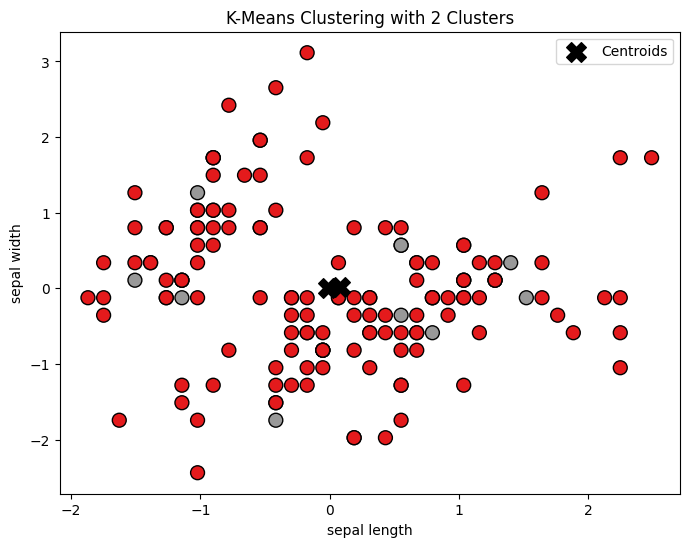

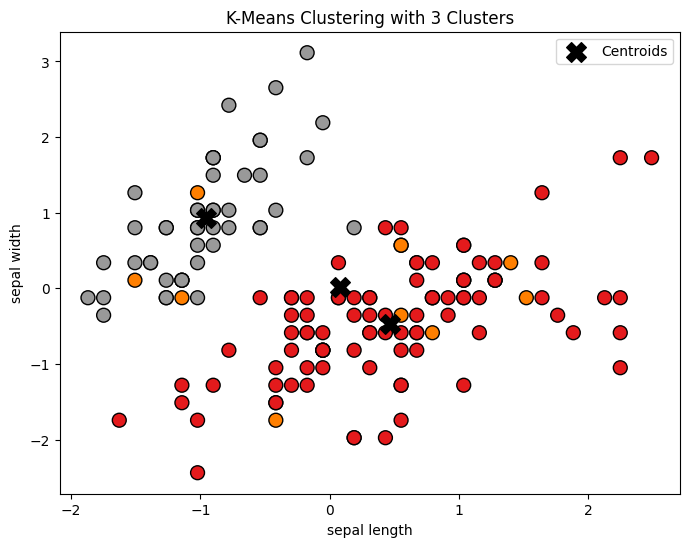

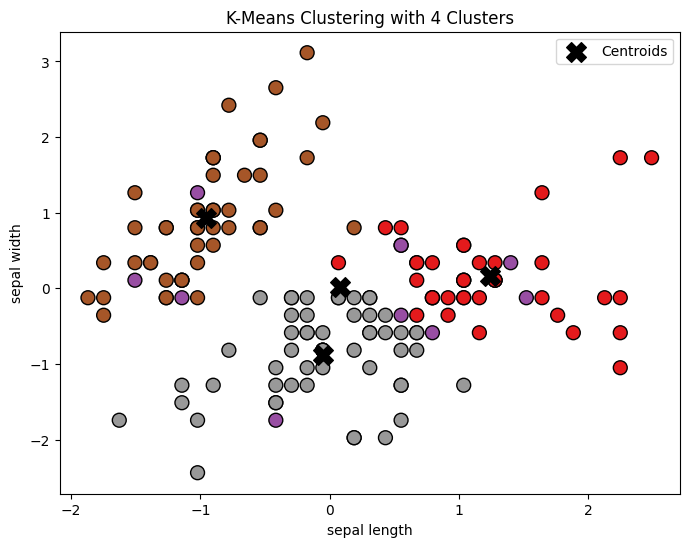

In [8]:
# 1. Siapkan fitur (X) dan label (y)
feature_names = ['sepal length', 'sepal width', 'petal_length', 'petal_width']
X = df_merged[feature_names].values
y = df_merged['class'].astype('category').cat.codes.values  # label dikodekan ke angka

# 2. Standarisasi data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# 3. Fungsi untuk melakukan K-Means, plotting dan menampilkan centroid
def perform_kmeans_plot(X_scaled, k):
    kmeans = KMeans(n_clusters=k, random_state=42)
    labels = kmeans.fit_predict(X_scaled)

    # Centroid dari masing-masing klaster
    centroids = kmeans.cluster_centers_

    # Plotting data dan centroid
    plt.figure(figsize=(8, 6))

    # Scatter plot untuk 2 fitur pertama (sepal length & sepal width)
    plt.scatter(X_scaled[:, 0], X_scaled[:, 1], c=labels, cmap='Set1', marker='o', edgecolors='k', s=100)

    # Plot centroid dengan warna berbeda
    plt.scatter(centroids[:, 0], centroids[:, 1], c='black', marker='X', s=200, label='Centroids')

    plt.title(f"K-Means Clustering with {k} Clusters")
    plt.xlabel(feature_names[0])
    plt.ylabel(feature_names[1])
    plt.legend()
    plt.show()

# 4. Melakukan clustering dengan K=2, K=3, dan K=4 dan plot hasilnya
for k in [2, 3, 4]:
    perform_kmeans_plot(X_scaled, k)

### Menghitung Inertia

In [9]:
# 1. Siapkan fitur (X) dan label (y)
feature_names = ['sepal length', 'sepal width', 'petal_length', 'petal_width']
X = df_merged[feature_names].values
y = df_merged['class'].astype('category').cat.codes.values  # label dikodekan ke angka

# 2. Standarisasi data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# 3. Fungsi untuk menghitung inertia secara manual
def calculate_inertia_step_by_step(X_scaled, labels, centroids):
    inertia = 0
    print("Langkah-langkah perhitungan Inertia:")

    for i in range(len(X_scaled)):
        cluster = labels[i]
        distance = np.linalg.norm(X_scaled[i] - centroids[cluster]) ** 2
        inertia += distance
        print(f"Titik data {i+1} (Fitur: {X_scaled[i]}), Klaster: {cluster}, "
              f"Centroid: {centroids[cluster]}, Jarak kuadrat: {distance:.3f}, "
              f"Inertia sementara: {inertia:.3f}")

    return inertia

# 4. Fungsi untuk menjalankan KMeans dan menghitung inertia manual
def perform_kmeans(X_scaled, y, k):
    kmeans = KMeans(n_clusters=k, random_state=42)
    labels = kmeans.fit_predict(X_scaled)
    centroids = kmeans.cluster_centers_

    print(f"\n=== Hasil K-Means dengan {k} Klaster ===")
    print(f"Centroids (fitur hasil standarisasi):\n{centroids}")

    # Hitung inertia manual
    manual_inertia = calculate_inertia_step_by_step(X_scaled, labels, centroids)
    print(f"\nTotal Inertia Manual: {manual_inertia:.3f}")

    # Bandingkan dengan inertia dari sklearn
    sklearn_inertia = kmeans.inertia_
    print(f"Inertia dari sklearn: {sklearn_inertia:.3f}")
    print("="*50)

    return labels, centroids, manual_inertia

# 5. Jalankan untuk k=2, 3, dan 4
for k in [2, 3, 4]:
    perform_kmeans(X_scaled, y, k)



=== Hasil K-Means dengan 2 Klaster ===
Centroids (fitur hasil standarisasi):
[[-8.52662792e-03 -1.54268643e-03 -3.31738811e-01 -3.31633439e-01]
 [ 7.67396513e-02  1.38841779e-02  2.98564930e+00  2.98470095e+00]]
Langkah-langkah perhitungan Inertia:
Titik data 1 (Fitur: [-0.90068117  1.03205722  2.4871142   2.37163679]), Klaster: 1, Centroid: [0.07673965 0.01388418 2.9856493  2.98470095], Jarak kuadrat: 2.616, Inertia sementara: 2.616
Titik data 2 (Fitur: [-1.14301691 -0.1249576   2.67710773  2.55635649]), Klaster: 1, Centroid: [0.07673965 0.01388418 2.9856493  2.98470095], Jarak kuadrat: 1.786, Inertia sementara: 4.402
Titik data 3 (Fitur: [-1.38535265  0.33784833  2.89085044  2.67950296]), Klaster: 1, Centroid: [0.07673965 0.01388418 2.9856493  2.98470095], Jarak kuadrat: 2.345, Inertia sementara: 6.747
Titik data 4 (Fitur: [-1.50652052  0.10644536  2.6147661   2.67950296]), Klaster: 1, Centroid: [0.07673965 0.01388418 2.9856493  2.98470095], Jarak kuadrat: 2.746, Inertia sementara: 

### Model Plotting Diagram Elbow Method

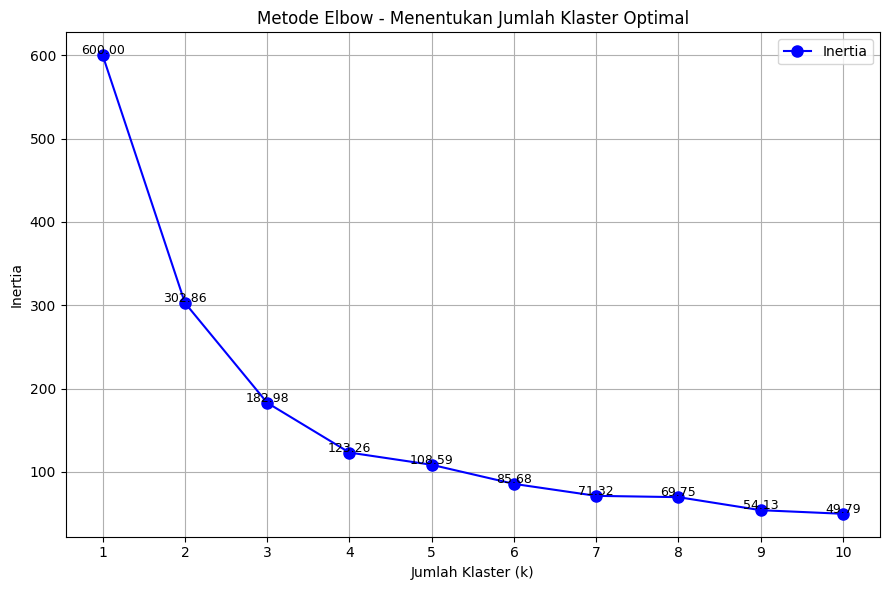

In [10]:
# 1. Siapkan fitur (X) dan label (y)
feature_names = ['sepal length', 'sepal width', 'petal_length', 'petal_width']
X = df_merged[feature_names].values
y = df_merged['class'].astype('category').cat.codes.values  # label dikodekan ke angka

# 2. Standarisasi data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# 3. Hitung inertia untuk berbagai nilai k
inertias = []
K_range = range(1, 11)

for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X_scaled)
    inertias.append(kmeans.inertia_)

# 4. Plot Elbow Diagram
plt.figure(figsize=(9, 6))
plt.plot(K_range, inertias, 'bo-', markersize=8, label='Inertia')
plt.title("Metode Elbow - Menentukan Jumlah Klaster Optimal")
plt.xlabel("Jumlah Klaster (k)")
plt.ylabel("Inertia")
plt.xticks(K_range)
plt.grid(True)

# Tambahkan label inertia di tiap titik
for i, inertia in enumerate(inertias):
    plt.text(K_range[i], inertias[i] + 1, f"{inertia:.2f}", ha='center', fontsize=9)

plt.legend()
plt.tight_layout()
plt.show()

### Menghitung Silhouette Score untuk Jumlah Cluster


=== Hasil K-Means dengan 2 Klaster ===
Centroids:
[[-8.52662792e-03 -1.54268643e-03 -3.31738811e-01 -3.31633439e-01]
 [ 7.67396513e-02  1.38841779e-02  2.98564930e+00  2.98470095e+00]]
Silhouette Score untuk 2 klaster: 0.646

=== Hasil K-Means dengan 3 Klaster ===
Centroids:
[[ 0.46447684 -0.4694909  -0.2990287  -0.31754001]
 [ 0.07673965  0.01388418  2.9856493   2.98470095]
 [-0.95453356  0.93435375 -0.39715903 -0.3598203 ]]
Silhouette Score untuk 3 klaster: 0.457

=== Hasil K-Means dengan 4 Klaster ===
Centroids:
[[ 1.23995121  0.15786825 -0.27900681 -0.3077396 ]
 [ 0.07673965  0.01388418  2.9856493   2.98470095]
 [-0.95453356  0.93435375 -0.39715903 -0.3598203 ]
 [-0.05250608 -0.88773034 -0.31237662 -0.32407361]]
Silhouette Score untuk 4 klaster: 0.454

>>> Jumlah cluster terbaik dengan dengan Silhouette Score mendekati 1 adalah k = 2 (dengan score = 0.646)


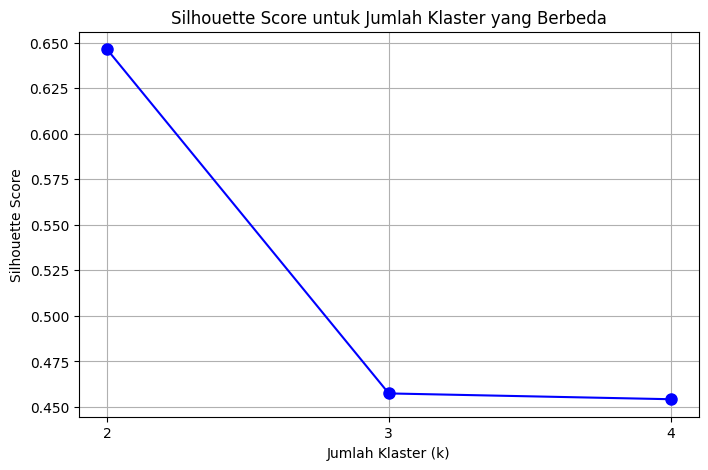

In [11]:
# 1. Siapkan fitur (X) dan label (y)
feature_names = ['sepal length', 'sepal width', 'petal_length', 'petal_width']
X = df_merged[feature_names].values
y = df_merged['class'].astype('category').cat.codes.values  # label dikodekan ke angka

# 2. Standarisasi data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# 3. Fungsi untuk melakukan K-Means dan menghitung Silhouette Score
def perform_kmeans_with_silhouette(X_scaled, k):
    kmeans = KMeans(n_clusters=k, random_state=42)
    labels = kmeans.fit_predict(X_scaled)

    # Menghitung Silhouette Score
    silhouette_avg = silhouette_score(X_scaled, labels)

    # Centroid dari masing-masing klaster
    centroids = kmeans.cluster_centers_

    # Output hasil untuk klaster k
    print(f"\n=== Hasil K-Means dengan {k} Klaster ===")
    print(f"Centroids:\n{centroids}")
    print(f"Silhouette Score untuk {k} klaster: {silhouette_avg:.3f}")

    return silhouette_avg

# 4. Melakukan clustering dan menghitung Silhouette Score untuk k=2, 3, dan 4
silhouette_scores = []
k_values = [2, 3, 4]

for k in k_values:
    score = perform_kmeans_with_silhouette(X_scaled, k)
    silhouette_scores.append(score)

# 5. Menentukan k dengan Silhouette Score terbaik
best_k = k_values[np.argmax(silhouette_scores)]
best_score = max(silhouette_scores)
print(f"\n>>> Jumlah cluster terbaik dengan dengan Silhouette Score mendekati 1 adalah k = {best_k} (dengan score = {best_score:.3f})")

# 6. Plot Silhouette Scores
plt.figure(figsize=(8, 5))
plt.plot(k_values, silhouette_scores, 'bo-', markersize=8)
plt.title("Silhouette Score untuk Jumlah Klaster yang Berbeda")
plt.xlabel("Jumlah Klaster (k)")
plt.ylabel("Silhouette Score")
plt.xticks(k_values)
plt.grid(True)
plt.show()